In [2]:
from Fundamentals import Dirichlet, PPEProbabilities, optimize_ppe
import jax.numpy as jnp
import numpy as np
import scipy.special as sps
import jax.scipy.stats as scs
import matplotlib.pyplot as plt

## Example 1: Simple Gaussian model

We assume $ Y \sim \mathcal{N}(\theta, \sigma)$, with $\theta \sim \mathcal{N}(\mu_1, \sigma_1)$. Then, we have the hyperparameter vector $\pmb{\lambda} = [\mu_1, \sigma, \sigma_1]$. Also, for $ A = (a,b] $, we know that 

$$\mathbb{P}_{A|\pmb{\lambda}} = \Phi \Big((b - \mu_1)/\sqrt{\sigma^2 + \sigma_1^2} \Big) - \Phi \Big((a - \mu_1)/\sqrt{\sigma^2 + \sigma_1^2} \Big)$$

### Optimizing $\lambda$ only

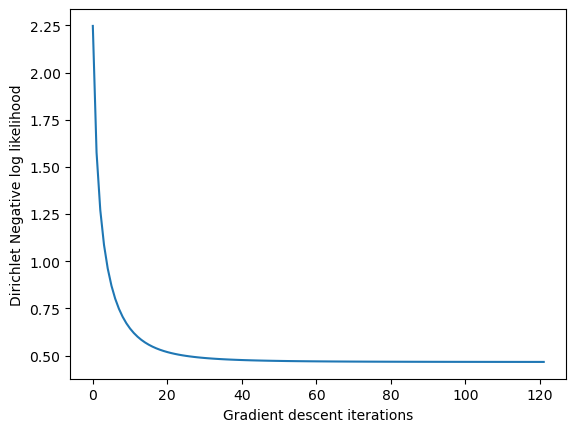

In [20]:
## We define the prior predictive distribution (ppd) for the gaussian model:

def get_gaussian_probs(partition, lam):
    
    mu_1 = lam[0]
    sigma = lam[1]
    sigma_1 = lam[2]
    
    p1 = scs.norm.cdf((partition[1] - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2)) - scs.norm.cdf((partition[0] - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2))    
    
    return p1


opt_class = optimize_ppe(alpha=1, ppd=get_gaussian_probs)


### The lower and upper partitions should be wide enough so that the probabilities sum to 1!

partitions = [np.array([[-1000,-2], [-2, 3], [3, 1000]]),
              np.array([[-1000,-1], [-1, 1000]])]

expert_probs = [np.array([0.2, 0.7, 0.1]),
                np.array([0.7, 0.3])]

lam_new, lik_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=np.ones(3)*2, iters = 1000, step_size=0.1, tol = 1e-5)



plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [21]:
lam_new

Array([-0.35006088,  3.1652663 ,  3.1652663 ], dtype=float32)

In [22]:
opt_class.get_alpha(partitions, lam_new, expert_probs)

4.7094084678171315

### Optimizing both $\alpha$ and $\lambda$

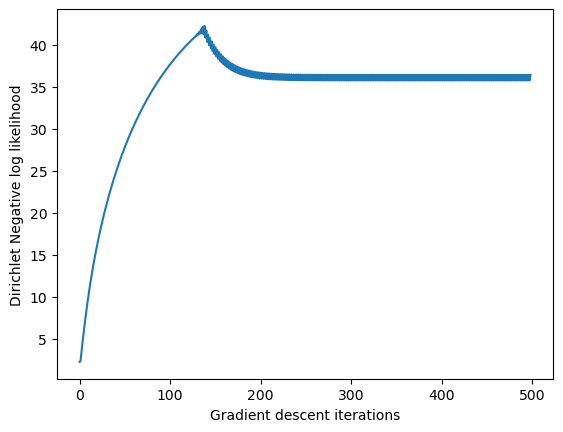

In [23]:
opt_class = optimize_ppe(None, ppd=get_gaussian_probs)

lam_new, alpha_best, lik_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=np.ones(3)*2, iters = 499, step_size=0.5, tol = 1e-4) # takes ~30 sec

plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [24]:
lam_new

Array([-1.25826  ,  2.0612078,  2.0612078], dtype=float32)

In [25]:
alpha_best  ## alpha as found from the optimization process

Array(7.6038966, dtype=float32)

In [26]:
opt_class.get_alpha(partitions, lam_new, expert_probs)  ## resulting alpha from the MLE closed form solution for the optimized hyperparameters lambda

9.142902250600939

## Second example: binary classification in the presence of covariates (taken from the paper)

We consider a generative model for binary data in the presence of a vector of covariates. The observable variable conditioned on the parameters is distributed according to a Bernoulli model and we take a multivariate Gaussian distribution as the prior distribution for the vector of parameters in the predictor function. This can be formalized as:

$$ y|\pmb{\theta} \sim \pmb{\mathcal{B}(\Phi (\pmb{x}^{\text{T}}\pmb{\theta}))}, $$

where

$$\pmb{\theta} \sim \mathcal{N}_D(\mu, \Sigma).$$

This gives us

$$ y \sim \mathcal{B}(p(\pmb{x}, \pmb{\lambda})),$$

where 

$$ p(\pmb{x}, \pmb{\lambda}) = \Phi \Big(\frac{\pmb{x}^{\text{T}}\pmb{\mu}}{\sqrt{1 + \pmb{x}^{\text{T}}\Sigma\pmb{x}}}\Big).$$

Our hyperparameter set is defined as $\pmb{\lambda} = [\mu, \Sigma]$. Since we have binary classification, there are only two partitions, ${0,1}$. If we define $A_1 = \mathbb{P}(y=0)$ and $A_2 = \mathbb{P}(y=1)$ we get:

$$\mathbb{P}_{A_1 | \pmb{\lambda}} = 1 -  p(\pmb{x}^{\text{T}}\pmb{\lambda}) \text{ and } \mathbb{P}_{A_2 | \pmb{\lambda}} = p(\pmb{x}^{\text{T}}\pmb{\lambda}).$$

For this example we assume $N=3$ and that the variables are independent with one another, meaning that $\Sigma$ is a diagonal matrix.

### Optimizing $\lambda$ only

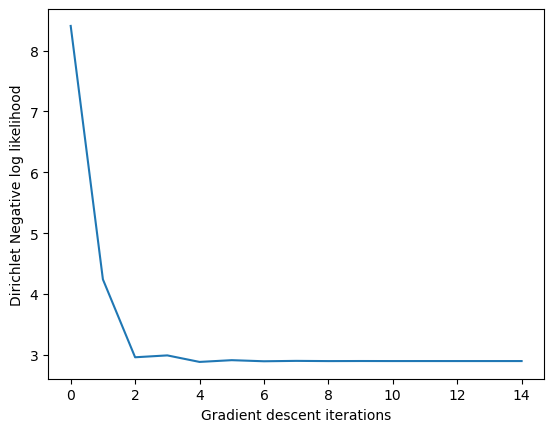

In [27]:
def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:3]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[3:]))@covariate_set)
    
    p1 = 1 - scs.norm.cdf(nom / den)
    
    if partition == 0:
        return p1
    
    return 1 - p1




opt_class = optimize_ppe(alpha=2, ppd=get_bernoulli_probs)

### The lower and upper partitions should be wide enough so that the probabilities sum to 1

partitions = [np.array([0,1]),
              np.array([0,1]),
              np.array([0,1])]

expert_probs = [np.array([0.35, 0.65]),
                np.array([0.3, 0.7]),
                np.array([0.2, 0.8])]

total_covariate_sets = [np.array([1.3, 0.7, 0.5]),
                        np.array([1, 0.5, 0.4]),
                        np.array([0.3, 0.7, 2])]

lam_new, lik_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=np.ones(6)*2.0, iters = 1000, step_size=0.5, tol = 1e-5, total_covariates=total_covariate_sets)


plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [28]:
lam_new

Array([-0.03406842,  0.7674872 ,  0.6939185 ,  3.4945354 ,  2.5090697 ,
        3.0954976 ], dtype=float32)

In [29]:
opt_class.get_alpha(partitions, lam_new, expert_probs, total_covariate_sets)

25.92587134562614

### Optimizing both $\alpha$ and $\lambda$

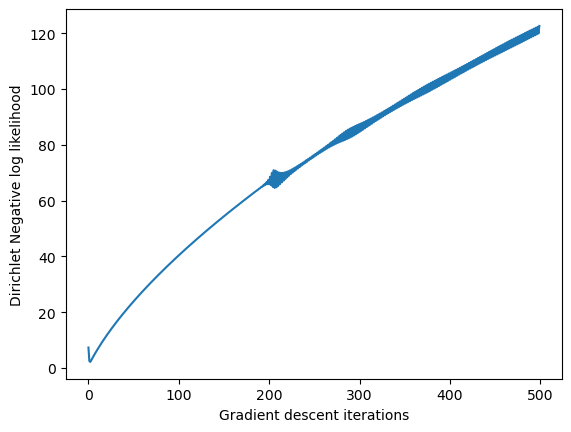

In [30]:
opt_class = optimize_ppe(alpha=None, ppd=get_bernoulli_probs)
lam_new, alpha_best, lik_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=np.ones(6)*2.0, iters = 500, step_size=0.2, tol = 1e-4, total_covariates=total_covariate_sets)


plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [31]:
lam_new

Array([ 0.8571092 , -0.28155786,  1.940221  ,  5.4214816 ,  3.2806075 ,
        4.272827  ], dtype=float32)

In [32]:
alpha_best ## alpha as found from the optimization process

Array(16.959524, dtype=float32)

In [33]:
opt_class.get_alpha(partitions, lam_new, expert_probs, total_covariate_sets) ## resulting alpha from the MLE closed form solution for the optimized hyperparameters lambda

244.79875493233047

In [34]:
print(expert_probs)

[array([0.35, 0.65]), array([0.3, 0.7]), array([0.2, 0.8])]
